In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import os
import tqdm
from collections import namedtuple

In [3]:
import glob

## Functions

In [4]:
def histoplot(var, xlabel, ylabel, bins=100, figsize=(4,4), title=""):
    fig, ax = plt.subplots(1, 1, figsize=(4,4))
    h = plt.hist(var,bins)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    return h[0],h[1]

In [5]:
def prgroup(grdf, ng=1):
    i = 1
    for name, group in grdf:
        print(f"Group: {name}")
        print(group, "\n")
        i+=1
        if i > ng:
            break

In [6]:
def event_ekin(df):
    grdf = df.groupby('event_id')
    ekin = grdf['kin_energy'].sum()
    return ekin

In [7]:
def event_size(df):
    return len(np.unique(df.event_id))

In [8]:
def xindex(x,sx):
    return np.floor((x + xmin +dx)/sx)

def yindex(x, sy):
    return np.floor((x + ymin +dy)/sy)

def zindex(x, sz):
    return np.floor((x - zmin)/sz)


In [12]:
def voxelize(gdfx,mcrst,sx,sy,sz,ecut,case='pixel'):
    gdf = gdfx.copy()
    nx = int(mcrst.dx/sx)
    ny = int(mcrst.dy/sy)
    nz = int(mcrst.dz/sz)
    
    print(f"nx = {nx}, ny = {ny}, nz = {nz}")
    print(f"number of voxels = {nx*ny*nz}")
    print(f"index for xmin ={xindex(mcrst.xmin, sx)} index for xmax ={xindex(mcrst.xmax, sx)}")
    print(f"index for ymin ={yindex(mcrst.ymin, sy)} index for ymax ={yindex(mcrst.ymax, sy)}")
    print(f"index for zmin ={zindex(mcrst.zmin, sz)} index for zmax ={zindex(mcrst.zmax, sz)}")

    gdf["ix"]= xindex(gdf.final_x.values, sx).astype(int)
    gdf["iy"]= yindex(gdf.final_y.values, sy).astype(int)
    gdf["iz"]= zindex(gdf.final_z.values, sz).astype(int)

    if case == 'pixel':
        grdf = gdf.groupby(['event_id', 'ix', 'iy'])
    else:
         grdf = gdf.groupby(['event_id', 'ix', 'iy', 'iz'])

    gdf = grdf.agg(
                ebox = ('kin_energy', 'sum'),
                tbox = ('initial_t', 'mean'),     
                xbox = ('final_x', 'mean'),     
                ybox = ('final_y', 'mean'),        
                zbox = ('final_z', 'mean'),        # z in the box is the y mean
                nbox = ('final_z', 'count'),
                  ).reset_index()
    
    return gdf

In [13]:
def pixelated(gdfx,mcrst,sx,sy,sz, ecut, case='pixel'):
    gdf = voxelize(gdfx,mcrst,sx,sy,sz, ecut)
    gdf =gdf[gdf.ebox >ecut]
    return event_size(gdf)

In [14]:
def streams(gdx):
    gdf  = gdx.copy()
    grdf = gdf.groupby('event_id')
    gdf  = grdf.agg(#event_id = ('event_id', 'first'),
                etot = ('ebox', 'sum'),
                ngama = ('ebox', 'count')
                  ).reset_index()

    df1g = gdf[gdf.ngama==1]
    df2g = gdf[gdf.ngama==2]
    dfng = gdf[gdf.ngama>2]
    print(f" fraction of events 1g = {(event_size(df1g)/event_size(gdf)):.2f}")
    print(f" fraction of events 2g = {(event_size(df2g)/event_size(gdf)):.2f}")
    print(f" fraction of events >3g = {(event_size(dfng)/event_size(gdf)):.2f}")
    return df1g,df2g,dfng
   

## Globals

In [15]:
path_to_data=os.environ['MONOLITH_DATA'] 

In [16]:
npr=10
eth = 0.001 # in keV
lmax = 60 # in mm

## Code

In [17]:
dir = os.path.join(path_to_data,"CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5")

In [18]:
# Define the pattern to match all .txt files in the 'documents' directory
pattern = f'{dir}/*.h5'

# Use glob to find all files matching the pattern
file_paths = glob.glob(pattern)



In [19]:
def select_gammas_interact_in_crystal(df):
    grdf = df.groupby('event_id')
    return grdf.filter(lambda x: ((x.mother_id == 0) & (x['final_volume'] == 'CRYSTAL')).any() )



In [20]:
def concat_df(file_paths, start=0, end=10):
    DF =[]
    for file in file_paths[start:end]:
        gammas = pd.read_hdf(file,"MC/particles")
        DF.append(gammas.drop(['initial_momentum_x', 'initial_momentum_y', 'initial_momentum_z',
                 'final_momentum_x', 'final_momentum_y', 'final_momentum_z',
                'final_proc', 'final_t'], axis=1))
                      
    return pd.concat(DF, axis=0)

In [21]:
gammas = concat_df(file_paths, start=0, end=10)

In [22]:
gammas.head(npr)

,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,final_y,final_z,initial_volume,final_volume,kin_energy,length,creator_proc
0,680000,2,e-,0,1,5.697865,-19.175293,13.270716,0.062953,5.698732,-19.170427,13.269436,CRYSTAL,CRYSTAL,0.056891,0.015492,compt
1,680000,1,gamma,1,0,5.697865,-19.175293,-5.602252,0.000000,-1285.906128,-6744.805664,12500.000000,LAB,WORLD,0.511000,14260.387695,none
2,680001,1,gamma,1,0,-23.934303,17.354870,-5.762755,0.000000,-2462.812256,-6939.754883,12500.000000,LAB,WORLD,0.511000,14523.655273,none
3,680001,2,e-,0,1,-23.934303,17.354870,42.051094,0.159490,-23.931292,17.360579,42.054077,CRYSTAL,CRYSTAL,0.062284,0.024965,compt
4,680002,2,e-,0,1,17.471272,-21.407799,15.194095,0.070294,17.471382,-21.446926,15.220994,CRYSTAL,CRYSTAL,0.212338,0.101784,compt
5,680002,25621,e-,0,1,16.308014,-8.935721,20.914680,0.116228,16.307983,-8.935692,20.914715,CRYSTAL,CRYSTAL,0.002909,0.000255,compt
6,680002,1,gamma,1,0,17.471272,-21.407799,-5.879397,0.000000,15.823273,-6.602371,22.563520,LAB,CRYSTAL,0.511000,37.742111,none
7,680002,26109,e-,0,1,15.823273,-6.602371,22.563520,0.125894,15.823278,-6.602430,22.563559,CRYSTAL,CRYSTAL,0.003268,0.000251,phot
8,680002,26108,e-,0,1,15.823273,-6.602371,22.563520,0.125894,15.823315,-6.602375,22.563528,CRYSTAL,CRYSTAL,0.003892,0.000309,phot
9,680002,26107,e-,0,1,15.823273,-6.602371,22.563520,0.125894,15.821968,-6.599888,22.562878,CRYSTAL,CRYSTAL,0.025294,0.005837,phot


### Select events in which gammas interact in crystal 

In [23]:
filter_gammas_in_crystal = True

In [24]:
if filter_gammas_in_crystal:
    gdf1 = select_gammas_interact_in_crystal(gammas)
else:
    gdf1 = gammas

In [25]:
gdf1.head(npr)

,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,final_y,final_z,initial_volume,final_volume,kin_energy,length,creator_proc
4,680002,2,e-,0,1,17.471272,-21.407799,15.194095,0.070294,17.471382,-21.446926,15.220994,CRYSTAL,CRYSTAL,0.212338,0.101784,compt
5,680002,25621,e-,0,1,16.308014,-8.935721,20.914680,0.116228,16.307983,-8.935692,20.914715,CRYSTAL,CRYSTAL,0.002909,0.000255,compt
6,680002,1,gamma,1,0,17.471272,-21.407799,-5.879397,0.000000,15.823273,-6.602371,22.563520,LAB,CRYSTAL,0.511000,37.742111,none
7,680002,26109,e-,0,1,15.823273,-6.602371,22.563520,0.125894,15.823278,-6.602430,22.563559,CRYSTAL,CRYSTAL,0.003268,0.000251,phot
8,680002,26108,e-,0,1,15.823273,-6.602371,22.563520,0.125894,15.823315,-6.602375,22.563528,CRYSTAL,CRYSTAL,0.003892,0.000309,phot
9,680002,26107,e-,0,1,15.823273,-6.602371,22.563520,0.125894,15.821968,-6.599888,22.562878,CRYSTAL,CRYSTAL,0.025294,0.005837,phot
10,680002,26106,e-,0,1,15.823273,-6.602371,22.563520,0.125894,15.726667,-6.617984,22.585983,CRYSTAL,CRYSTAL,0.258608,0.268714,phot
18,680005,3,e-,0,1,6.790020,7.181014,32.762108,0.128651,6.789917,7.181046,32.762138,CRYSTAL,CRYSTAL,0.005044,0.000415,compt
19,680005,2,e-,0,1,6.790020,7.181014,32.762108,0.128651,6.709959,7.169606,32.762215,CRYSTAL,CRYSTAL,0.222331,0.211838,compt
20,680005,27589,e-,0,1,15.265637,4.257829,35.750702,0.160174,15.278877,4.246835,35.761810,CRYSTAL,CRYSTAL,0.080053,0.054636,compt


In [26]:
event_size(gdf1)/event_size(gammas)

0.6570849527327767

### Remove primary gammas from dataframe

In [27]:
gdf2 = gdf1[gdf1['mother_id'] != 0]
gdf2.head(npr)

,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,final_y,final_z,initial_volume,final_volume,kin_energy,length,creator_proc
4,680002,2,e-,0,1,17.471272,-21.407799,15.194095,0.070294,17.471382,-21.446926,15.220994,CRYSTAL,CRYSTAL,0.212338,0.101784,compt
5,680002,25621,e-,0,1,16.308014,-8.935721,20.914680,0.116228,16.307983,-8.935692,20.914715,CRYSTAL,CRYSTAL,0.002909,0.000255,compt
7,680002,26109,e-,0,1,15.823273,-6.602371,22.563520,0.125894,15.823278,-6.602430,22.563559,CRYSTAL,CRYSTAL,0.003268,0.000251,phot
8,680002,26108,e-,0,1,15.823273,-6.602371,22.563520,0.125894,15.823315,-6.602375,22.563528,CRYSTAL,CRYSTAL,0.003892,0.000309,phot
9,680002,26107,e-,0,1,15.823273,-6.602371,22.563520,0.125894,15.821968,-6.599888,22.562878,CRYSTAL,CRYSTAL,0.025294,0.005837,phot
10,680002,26106,e-,0,1,15.823273,-6.602371,22.563520,0.125894,15.726667,-6.617984,22.585983,CRYSTAL,CRYSTAL,0.258608,0.268714,phot
18,680005,3,e-,0,1,6.790020,7.181014,32.762108,0.128651,6.789917,7.181046,32.762138,CRYSTAL,CRYSTAL,0.005044,0.000415,compt
19,680005,2,e-,0,1,6.790020,7.181014,32.762108,0.128651,6.709959,7.169606,32.762215,CRYSTAL,CRYSTAL,0.222331,0.211838,compt
20,680005,27589,e-,0,1,15.265637,4.257829,35.750702,0.160174,15.278877,4.246835,35.761810,CRYSTAL,CRYSTAL,0.080053,0.054636,compt
22,680005,37070,e-,0,1,18.203693,2.432415,30.927778,0.179971,18.203707,2.432456,30.927786,CRYSTAL,CRYSTAL,0.003284,0.000166,phot


In [28]:
event_size(gdf2)/event_size(gammas)

0.6570849527327767

### Remove particles not coming from primary to avoid double counting in energy deposition

In [29]:
grdf = gdf2.groupby('event_id')
gdf3 = grdf.apply(lambda x: x[x['mother_id'] == 1]).reset_index(drop=True)
gdf3.head(npr)

,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,final_y,final_z,initial_volume,final_volume,kin_energy,length,creator_proc
0,80000,2,e-,0,1,5.410841,-2.503098,27.528318,0.111498,5.416837,-2.513758,27.536390,CRYSTAL,CRYSTAL,0.072773,0.046293,compt
1,80000,8653,e-,0,1,-4.326902,6.266281,30.262753,0.157675,-4.326416,6.265924,30.263420,CRYSTAL,CRYSTAL,0.020861,0.004293,compt
2,80000,8652,e-,0,1,5.494294,-2.073138,28.190062,0.114145,5.515532,-2.100316,28.200865,CRYSTAL,CRYSTAL,0.148905,0.113272,compt
3,80000,29010,e-,0,1,-6.468779,6.699799,30.230259,0.164965,-6.488622,6.721188,30.374346,CRYSTAL,CRYSTAL,0.267142,0.311779,phot
4,80001,4,e-,0,1,23.959150,-6.985072,38.808884,0.148258,23.959150,-6.985101,38.808891,CRYSTAL,CRYSTAL,0.003043,0.000136,phot
5,80001,3,gamma,0,1,23.959150,-6.985072,38.808884,0.148258,12500.000000,-1001.128174,-6044.959473,CRYSTAL,WORLD,0.028609,13915.895508,phot
6,80001,2,e-,0,1,23.959150,-6.985072,38.808884,0.148258,23.864847,-7.054073,39.030182,CRYSTAL,CRYSTAL,0.477824,0.756403,phot
7,80002,3,e-,0,1,-5.889712,-4.328921,17.513109,0.079224,-5.889703,-4.328901,17.513010,CRYSTAL,CRYSTAL,0.003498,0.000272,phot
8,80002,2,e-,0,1,-5.889712,-4.328921,17.513109,0.079224,-5.789085,-4.393706,17.506561,CRYSTAL,CRYSTAL,0.505283,0.760222,phot
9,80003,4,e-,0,1,-12.340251,-21.046457,14.876266,0.070026,-12.340220,-21.046459,14.876268,CRYSTAL,CRYSTAL,0.003587,0.000256,phot


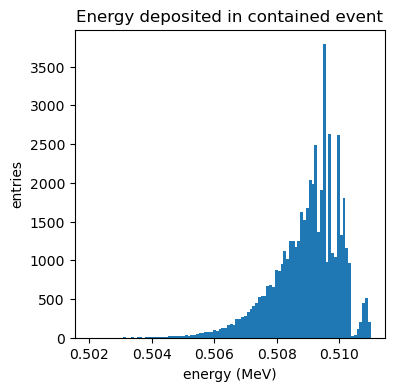

In [30]:
b, e = histoplot(event_ekin(gdf3), 'energy (MeV)', "entries", bins=100, figsize=(6,6),
                title="Energy deposited in contained event")

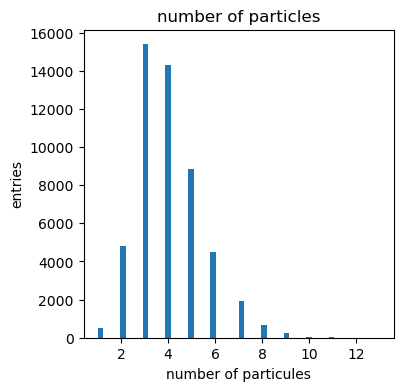

In [31]:
grdf = gdf3.groupby('event_id')
group_sizes = grdf.size()
b, e = histoplot(group_sizes, 'number of particules', "entries", bins=50, figsize=(4,4),
                title="number of particles")

## Impose threshold in energy and length

In [32]:
gdf4 = gdf3[(gdf3['kin_energy'] >eth) & (gdf3.length<lmax)]
gdf4.head(npr)

,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,final_y,final_z,initial_volume,final_volume,kin_energy,length,creator_proc
0,80000,2,e-,0,1,5.410841,-2.503098,27.528318,0.111498,5.416837,-2.513758,27.536390,CRYSTAL,CRYSTAL,0.072773,0.046293,compt
1,80000,8653,e-,0,1,-4.326902,6.266281,30.262753,0.157675,-4.326416,6.265924,30.263420,CRYSTAL,CRYSTAL,0.020861,0.004293,compt
2,80000,8652,e-,0,1,5.494294,-2.073138,28.190062,0.114145,5.515532,-2.100316,28.200865,CRYSTAL,CRYSTAL,0.148905,0.113272,compt
3,80000,29010,e-,0,1,-6.468779,6.699799,30.230259,0.164965,-6.488622,6.721188,30.374346,CRYSTAL,CRYSTAL,0.267142,0.311779,phot
4,80001,4,e-,0,1,23.959150,-6.985072,38.808884,0.148258,23.959150,-6.985101,38.808891,CRYSTAL,CRYSTAL,0.003043,0.000136,phot
6,80001,2,e-,0,1,23.959150,-6.985072,38.808884,0.148258,23.864847,-7.054073,39.030182,CRYSTAL,CRYSTAL,0.477824,0.756403,phot
7,80002,3,e-,0,1,-5.889712,-4.328921,17.513109,0.079224,-5.889703,-4.328901,17.513010,CRYSTAL,CRYSTAL,0.003498,0.000272,phot
8,80002,2,e-,0,1,-5.889712,-4.328921,17.513109,0.079224,-5.789085,-4.393706,17.506561,CRYSTAL,CRYSTAL,0.505283,0.760222,phot
9,80003,4,e-,0,1,-12.340251,-21.046457,14.876266,0.070026,-12.340220,-21.046459,14.876268,CRYSTAL,CRYSTAL,0.003587,0.000256,phot
10,80003,3,gamma,0,1,-12.340251,-21.046457,14.876266,0.070026,-12.131485,-21.234009,14.627576,CRYSTAL,CRYSTAL,0.028306,0.389036,phot


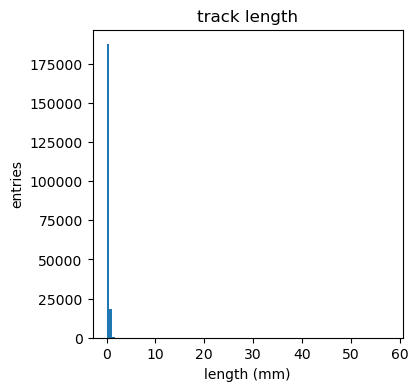

In [33]:
b, e = histoplot(gdf4.length, "length (mm)", "entries", bins=100, figsize=(4,4), title="track length")

### XYZ distributions

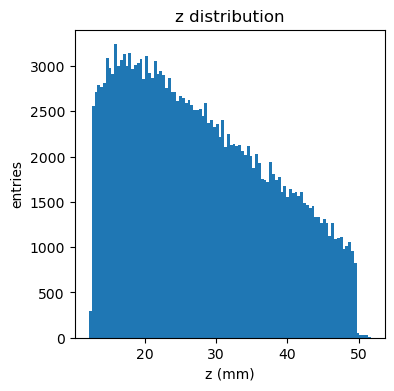

In [34]:
b, e = histoplot(gdf4.initial_z, "z (mm)", "entries", bins=100, figsize=(4,4),
                title="z distribution")

In [35]:
zmin = np.ceil(e[0])
zmax = np.floor(e[-1])
dz = zmax - zmin
print(f"zmax = {zmax:.2f}, zmin = {zmin:.2f}, dz = {dz:.2f}")

zmax = 51.00, zmin = 13.00, dz = 38.00


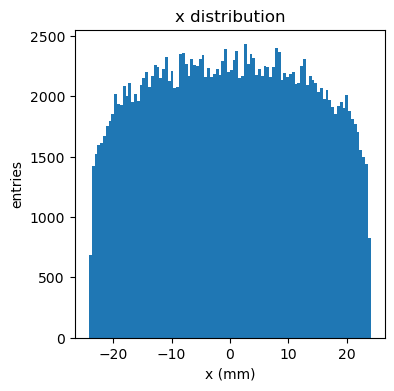

In [36]:
b, e = histoplot(gdf4.initial_x, "x (mm)", "entries", bins=100, figsize=(4,4),
                 title="x distribution")

In [37]:
xmin = -np.ceil(-e[0])
xmax = np.ceil(e[-1])
dx = xmax - xmin
print(f"xmax = {xmax:.2f}, xmin = {xmin:.2f}, dx = {dx:.2f}")

xmax = 25.00, xmin = -25.00, dx = 50.00


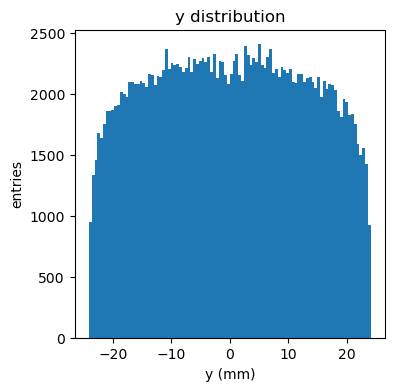

In [38]:
b, e = histoplot(gdf4.initial_y, "y (mm)", "entries", bins=100, figsize=(4,4),
                 title="y distribution")

In [39]:
ymin = -np.ceil(-e[0])
ymax = np.ceil(e[-1])
dy = ymax - ymin
print(f"ymax = {ymax:.2f}, ymin = {ymin:.2f}, dy = {dy:.2f}")

ymax = 25.00, ymin = -25.00, dy = 50.00


In [40]:
MCrst = namedtuple('MCrst','xmin xmax dx ymin ymax dy zmin zmax dz')
mcrst = MCrst(xmin, xmax, dx, ymin, ymax, dy, zmin, zmax, dz)
mcrst

MCrst(xmin=-25.0, xmax=25.0, dx=50.0, ymin=-25.0, ymax=25.0, dy=50.0, zmin=13.0, zmax=51.0, dz=38.0)

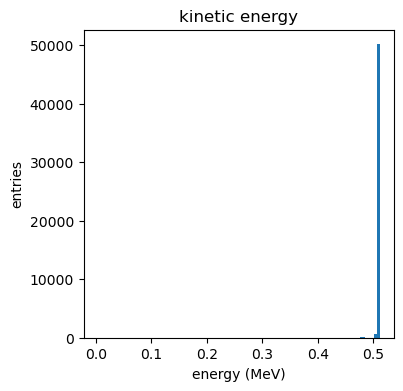

In [41]:
b, e = histoplot(event_ekin(gdf4), 'energy (MeV)', "entries", bins=100, figsize=(6,6),
                title="kinetic energy")

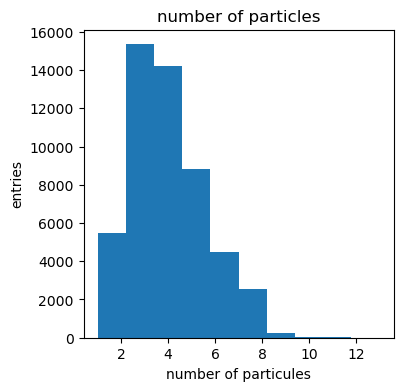

In [42]:
grdf = gdf4.groupby('event_id')
group_sizes = grdf.size()
b, e = histoplot(group_sizes, 'number of particules', "entries", bins=10, figsize=(4,4,),
                title="number of particles")

In [43]:
fce = event_size(gdf4)/event_size(gammas)
print(f"Fraction of events contained in crystal = {(fce):.2f}")

Fraction of events contained in crystal = 0.66


In [44]:
gdf5 = gdf4.drop(['initial_x', 'initial_y', 'initial_z', 
                  'primary', 'mother_id', 'initial_volume', 'final_volume'], axis=1)
gdf5.head(npr)

,event_id,particle_id,particle_name,initial_t,final_x,final_y,final_z,kin_energy,length,creator_proc
0,80000,2,e-,0.111498,5.416837,-2.513758,27.536390,0.072773,0.046293,compt
1,80000,8653,e-,0.157675,-4.326416,6.265924,30.263420,0.020861,0.004293,compt
2,80000,8652,e-,0.114145,5.515532,-2.100316,28.200865,0.148905,0.113272,compt
3,80000,29010,e-,0.164965,-6.488622,6.721188,30.374346,0.267142,0.311779,phot
4,80001,4,e-,0.148258,23.959150,-6.985101,38.808891,0.003043,0.000136,phot
6,80001,2,e-,0.148258,23.864847,-7.054073,39.030182,0.477824,0.756403,phot
7,80002,3,e-,0.079224,-5.889703,-4.328901,17.513010,0.003498,0.000272,phot
8,80002,2,e-,0.079224,-5.789085,-4.393706,17.506561,0.505283,0.760222,phot
9,80003,4,e-,0.070026,-12.340220,-21.046459,14.876268,0.003587,0.000256,phot
10,80003,3,gamma,0.070026,-12.131485,-21.234009,14.627576,0.028306,0.389036,phot


## Classification of events

## Select events in which the primary electron makes a photoelectric

In [51]:
grdf = gdf5.groupby('event_id')
gpe = grdf.filter(lambda x: ((x.particle_id == 2) & (x['creator_proc'] == 'phot')).any() )
gpe.head(npr)

,event_id,particle_id,particle_name,initial_t,final_x,final_y,final_z,kin_energy,length,creator_proc
4,80001,4,e-,0.148258,23.959150,-6.985101,38.808891,0.003043,0.000136,phot
6,80001,2,e-,0.148258,23.864847,-7.054073,39.030182,0.477824,0.756403,phot
7,80002,3,e-,0.079224,-5.889703,-4.328901,17.513010,0.003498,0.000272,phot
8,80002,2,e-,0.079224,-5.789085,-4.393706,17.506561,0.505283,0.760222,phot
9,80003,4,e-,0.070026,-12.340220,-21.046459,14.876268,0.003587,0.000256,phot
10,80003,3,gamma,0.070026,-12.131485,-21.234009,14.627576,0.028306,0.389036,phot
11,80003,2,e-,0.070026,-12.167717,-21.023403,14.976027,0.477824,0.628337,phot
41,80012,3,gamma,0.068149,-3.378542,7.785024,13.981870,0.032237,0.334044,phot
42,80012,2,e-,0.068149,-3.655060,7.863638,14.537817,0.477824,0.699527,phot
61,80018,4,e-,0.091211,8.760671,-16.124372,21.271732,0.003779,0.000294,phot


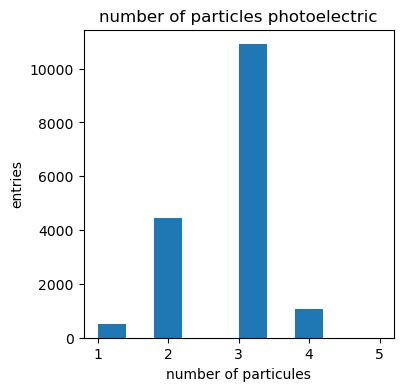

In [46]:
grdf = gpe.groupby('event_id')
group_sizes = grdf.size()
b, e = histoplot(group_sizes, 'number of particules', "entries", bins=10, figsize=(4,4),
                title="number of particles photoelectric")

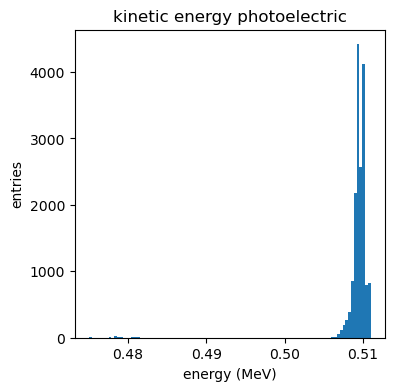

In [47]:
b, e = histoplot(event_ekin(gpe), 'energy (MeV)', "entries", bins=100, figsize=(4,4),
                title="kinetic energy photoelectric")

### Select the electron with energy closest to 0.511 keV
- NB due to Bremms, electron has energies above 0.4778, this value can be used to a cut

In [68]:
def efilter(ecut):
    def filter_ekin(group):
        return group[group['kin_energy'] > ecut]
    return filter_ekin
    

In [59]:
def filter_ekin(group):
    return group[group['kin_energy'] > 0.47]

In [60]:
photdf = gpe.groupby('event_id').apply(filter_ekin).reset_index(drop=True)

In [61]:
photdf.head(10)

,event_id,particle_id,particle_name,initial_t,final_x,final_y,final_z,kin_energy,length,creator_proc
0,80001,2,e-,0.148258,23.864847,-7.054073,39.030182,0.477824,0.756403,phot
1,80002,2,e-,0.079224,-5.789085,-4.393706,17.506561,0.505283,0.760222,phot
2,80003,2,e-,0.070026,-12.167717,-21.023403,14.976027,0.477824,0.628337,phot
3,80012,2,e-,0.068149,-3.655060,7.863638,14.537817,0.477824,0.699527,phot
4,80018,2,e-,0.091211,8.611866,-16.271351,21.467659,0.477824,0.649337,phot
5,80019,2,e-,0.099107,-2.556893,19.597635,23.327759,0.475013,0.660796,phot
6,80021,2,e-,0.105383,11.267675,-0.759515,25.744688,0.475013,0.714654,phot
7,80024,2,e-,0.109443,10.638188,14.147797,26.884428,0.505283,0.802716,phot
8,80025,2,e-,0.070300,-10.467741,-16.021576,15.194593,0.475013,0.768407,phot
9,80039,2,e-,0.106724,5.393916,14.636605,25.883747,0.477824,0.717809,phot


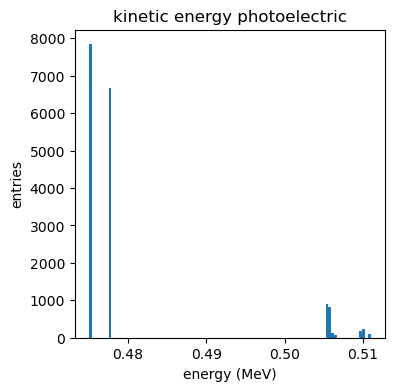

In [62]:
b, e = histoplot(photdf.kin_energy, 'energy (MeV)', "entries", bins=100, figsize=(4,4),
                title="kinetic energy photoelectric")

In [63]:
fphe = event_size(gpe)/event_size(gdf4)
print(f"Fraction of photoelectric events = {(fphe):.2f}")

Fraction of photoelectric events = 0.33


In [64]:
fphe2 = event_size(photdf)/event_size(gdf4)
print(f"Fraction of photoelectric events passing 1e cut = {(fphe2):.2f}")

Fraction of photoelectric events passing 1e cut = 0.33


## Select Compton

In [65]:
grdf = gdf5.groupby('event_id')
gcomp = grdf.filter(lambda x: ((x.particle_id == 2) & (x['creator_proc'] == 'compt')).any() )
gcomp.head(npr)

,event_id,particle_id,particle_name,initial_t,final_x,final_y,final_z,kin_energy,length,creator_proc
0,80000,2,e-,0.111498,5.416837,-2.513758,27.536390,0.072773,0.046293,compt
1,80000,8653,e-,0.157675,-4.326416,6.265924,30.263420,0.020861,0.004293,compt
2,80000,8652,e-,0.114145,5.515532,-2.100316,28.200865,0.148905,0.113272,compt
3,80000,29010,e-,0.164965,-6.488622,6.721188,30.374346,0.267142,0.311779,phot
12,80005,2,e-,0.139170,5.005468,4.002444,35.524548,0.337208,0.467442,compt
13,80005,40559,e-,0.141095,4.838688,4.123822,34.930439,0.044726,0.013322,compt
14,80005,46043,gamma,0.144832,4.291785,4.793588,35.639835,0.004920,0.001450,phot
15,80005,46042,e-,0.144832,4.293197,4.793855,35.639595,0.002956,0.000199,phot
16,80005,46040,e-,0.144832,4.291766,4.792620,35.640064,0.025616,0.007951,phot
17,80005,46039,e-,0.144832,4.285610,4.796286,35.643799,0.092828,0.057421,phot


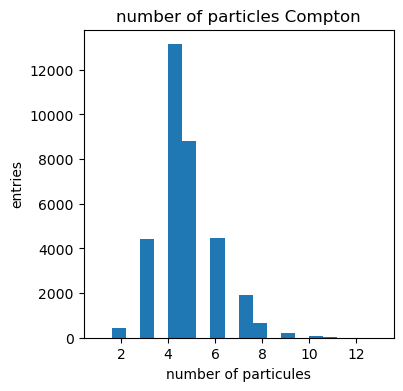

In [66]:
grdf = gcomp.groupby('event_id')
group_sizes = grdf.size()
b, e = histoplot(group_sizes, 'number of particules', "entries", bins=20, figsize=(4,4),
                title="number of particles Compton")

In [67]:
fcomp = event_size(gcomp)/event_size(gdf4)
print(f"Fraction of compton events = {(fcomp):.2f}")

Fraction of compton events = 0.67


### Select Comptons whose energy is near 511.
- One can set an energy cut to select events that are similar to photoelectric (e.g., large deposition of energy).
- For example, Ecut = 0.4 

In [71]:
f4 =efilter(0.4)

In [72]:
clkpdf = gcomp.groupby('event_id').apply(f4).reset_index(drop=True)

In [73]:
clkpdf.head(10)

,event_id,particle_id,particle_name,initial_t,final_x,final_y,final_z,kin_energy,length,creator_proc
0,80081,6649,e-,0.130984,-20.113060,-5.735755,31.642603,0.422149,0.653921,phot
1,80107,6950,e-,0.070302,-11.485571,14.028362,15.151979,0.419277,0.507280,phot
2,80175,926,e-,0.158058,16.641085,23.575001,41.092335,0.467116,0.659105,phot
3,80237,6479,e-,0.138705,2.285959,-20.049711,33.949673,0.421072,0.527743,phot
4,80244,3580,e-,0.129042,5.514588,13.956629,32.245815,0.475183,0.581087,phot
5,80324,6370,e-,0.136727,-4.792616,0.782480,34.030521,0.421654,0.498180,phot
6,80443,4588,e-,0.115461,0.327698,4.898690,28.038729,0.437058,0.558732,phot
7,80446,3,e-,0.067837,-7.498009,-0.546399,14.066834,0.455122,0.598830,phot
8,80453,796,e-,0.111888,-1.451508,-10.929814,27.070179,0.504363,0.480570,phot
9,80506,7808,e-,0.114292,-20.554140,-18.085691,26.946905,0.440120,0.611778,phot


In [74]:
fcomp2 = event_size(clkpdf)/event_size(gdf4)
print(f"Fraction of photo-like compton events = {(fcomp2):.2f}")

Fraction of photo-like compton events = 0.04


### Copy dataframe for later

In [57]:
gdx = gdf5.copy(deep=True)
gdy = gdf5.copy(deep=True)

## Case of Pixelated crystal
- Slice x,y in cells corresponding to the size of detector elements (e.g, 3x3 or 6x6)
- no slice in z

### Select events (pixelated case)
- Conditions:
- Energy within 5 % of 511 keV
- 1 pixel lighted

In [58]:
emin = 0.511 - 0.05*0.511
print(f"minimum energy: emin ={emin:.3f}")

minimum energy: emin =0.485


### Comparison between 6x6 and 3x3

In [59]:
npxl3x3 = pixelated(gdy,mcrst,sx=3,sy=3,sz=dz, ecut=emin)

nx = 16, ny = 16, nz = 1
number of voxels = 256
index for xmin =0.0 index for xmax =16.0
index for ymin =0.0 index for ymax =16.0
index for zmin =0.0 index for zmax =1.0


In [61]:
fpxsel3x3 = npxl3x3/event_size(gammas)
print(f"fraction of selected devents (wrt total events) pixelated 3x3 detector: {(fpxsel3x3):.2f}")

fraction of selected devents (wrt total events) pixelated 3x3 detector: 0.27


In [62]:
npxl6x6 = pixelated(gdy,mcrst,sx=6,sy=6,sz=dz,ecut=emin)

nx = 8, ny = 8, nz = 1
number of voxels = 64
index for xmin =0.0 index for xmax =8.0
index for ymin =0.0 index for ymax =8.0
index for zmin =0.0 index for zmax =1.0


In [63]:
fpxsel6x6 = npxl6x6/event_size(gammas)
print(f"fraction of selected devents (wrt total events) pixelated 6x6 detector: {(fpxsel6x6):.2f}")

fraction of selected devents (wrt total events) pixelated 6x6 detector: 0.34


## The case of monolithic crystal

- slice in (x,y,z).
- take the size of the slice equal to that of SiPM (e.g, 6x6)

In [64]:
gdm = gdx.copy()

In [65]:
gdm = voxelize(gdm,mcrst,sx=6,sy=6,sz=6,ecut=emin, case='mono')

nx = 8, ny = 8, nz = 6
number of voxels = 384
index for xmin =0.0 index for xmax =8.0
index for ymin =0.0 index for ymax =8.0
index for zmin =0.0 index for zmax =6.0


In [66]:
gdm.head(npr)

,event_id,ix,iy,iz,ebox,tbox,xbox,ybox,zbox,nbox
0,80000,3,5,2,0.288002,0.161320,-5.407519,6.493556,30.318882,2
1,80000,5,3,2,0.221678,0.112822,5.466185,-2.307037,27.868628,2
2,80001,8,2,4,0.477824,0.148258,23.864847,-7.054073,39.030182,1
3,80001,8,3,4,0.003043,0.148258,23.959150,-6.985101,38.808891,1
4,80002,3,3,0,0.508781,0.079224,-5.839395,-4.361304,17.509785,2
5,80003,2,0,0,0.509717,0.070026,-12.213141,-21.101290,14.826623,3
6,80005,4,4,3,0.171046,0.144084,4.400209,4.660034,35.498745,5
7,80005,5,4,3,0.337208,0.139170,5.005468,4.002444,35.524548,1
8,80007,0,6,4,0.264115,0.195250,-19.806046,15.336727,39.275658,4
9,80007,2,7,4,0.243590,0.151646,-7.875678,20.702217,39.180321,2


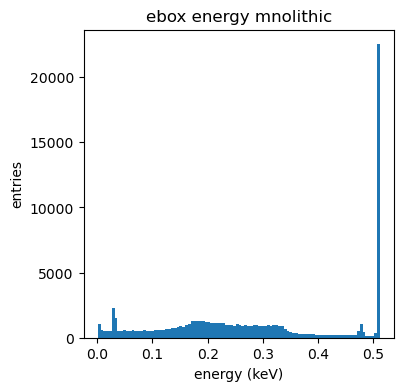

In [67]:
b, e = histoplot(gdm.ebox, "energy (keV)", "entries", bins=100, figsize=(4,4),
                title="ebox energy mnolithic")

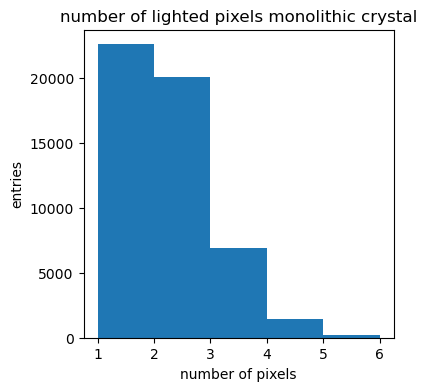

In [68]:
evts, evts_size = np.unique(gdm.event_id.values, return_counts=True)
b, e = histoplot(evts_size, "number of pixels", "entries", bins=5, figsize=(4,4),
                title="number of lighted pixels monolithic crystal") 

In [69]:
f1c = b[0]/np.sum(b)
f2c = b[1]/np.sum(b)
f3c = b[2]/np.sum(b)
print(f"fractions: 1 cluster ={f1c:.2f}")
print(f"fractions: 2 cluster ={f2c:.2f}")
print(f"fractions: 3 cluster ={f3c:.2f}")

fractions: 1 cluster =0.44
fractions: 2 cluster =0.39
fractions: 3 cluster =0.13


## Split data into three streams.
- Stream 1g: events with 1 cluster: true information: x,y,z,t,e
- Stream 2g: events with 2 clusters: true information: x1,y1,z1,t1,e1, x2,y2,z2,t2,e2
- Stream ng: events with more than 2 clusters: no true information needed

#### Strategy:
- First classify events as 1g, 2g or ng. This requires training a CNN with events of categories 1g, 2g, ng.
- Output of the net decides type of event.
- if 1g pass event through a second net trained with events of type 1g and find x,y,z.
- if 2g pass event through a second net trained with events of type 2g and find (x,y,z)_1,2
- if ng reject event

In [70]:
event_size(gdm)/event_size(gammas)

0.657033645027642

In [71]:
df1g,df2g,dfng = streams(gdm)

 fraction of events 1g = 0.44
 fraction of events 2g = 0.39
 fraction of events >3g = 0.17


In [72]:
gdmx = gdm.drop(['ix', 'iy', 'iz', 
                  'tbox', 'nbox'], axis=1)
gdmx.head(npr)

,event_id,ebox,xbox,ybox,zbox
0,80000,0.288002,-5.407519,6.493556,30.318882
1,80000,0.221678,5.466185,-2.307037,27.868628
2,80001,0.477824,23.864847,-7.054073,39.030182
3,80001,0.003043,23.959150,-6.985101,38.808891
4,80002,0.508781,-5.839395,-4.361304,17.509785
5,80003,0.509717,-12.213141,-21.101290,14.826623
6,80005,0.171046,4.400209,4.660034,35.498745
7,80005,0.337208,5.005468,4.002444,35.524548
8,80007,0.264115,-19.806046,15.336727,39.275658
9,80007,0.243590,-7.875678,20.702217,39.180321


In [73]:
gdm1c = gdmx[gdmx['event_id'].isin(df1g.event_id.values)]
gdm1c.head(npr)

,event_id,ebox,xbox,ybox,zbox
4,80002,0.508781,-5.839395,-4.361304,17.509785
5,80003,0.509717,-12.213141,-21.101290,14.826623
12,80009,0.508684,22.401775,-16.022129,30.625671
15,80012,0.510061,-3.516801,7.824331,14.259844
19,80014,0.508662,12.893323,17.883955,14.756919
25,80018,0.510212,8.710830,-16.172209,21.336302
26,80019,0.509274,-2.387278,19.475723,23.402334
35,80024,0.509166,10.710714,14.208286,26.957956
36,80025,0.509771,-10.221349,-16.074409,15.234952
49,80035,0.508818,-21.534344,6.691469,35.155281


In [74]:
gdm2c = gdmx[gdmx['event_id'].isin(df2g.event_id.values)]
gdm2c.head(npr)

,event_id,ebox,xbox,ybox,zbox
0,80000,0.288002,-5.407519,6.493556,30.318882
1,80000,0.221678,5.466185,-2.307037,27.868628
2,80001,0.477824,23.864847,-7.054073,39.030182
3,80001,0.003043,23.959150,-6.985101,38.808891
6,80005,0.171046,4.400209,4.660034,35.498745
7,80005,0.337208,5.005468,4.002444,35.524548
8,80007,0.264115,-19.806046,15.336727,39.275658
9,80007,0.243590,-7.875678,20.702217,39.180321
10,80008,0.105572,19.920361,15.164391,40.833527
11,80008,0.400685,20.626562,19.048475,39.545597


In [75]:
gdmnc = gdmx[gdmx['event_id'].isin(dfng.event_id.values)]
gdmnc.head(npr)

,event_id,ebox,xbox,ybox,zbox
16,80013,0.183127,-11.286137,-11.320441,17.851265
17,80013,0.157478,-8.728686,-9.935783,21.707445
18,80013,0.167359,-4.348894,-15.485699,21.686653
22,80017,0.230255,-22.647808,3.412830,40.294998
23,80017,0.220423,-15.164186,13.158697,48.158855
24,80017,0.057272,-13.194607,19.714655,38.109745
29,80022,0.258680,-9.667471,2.040165,22.167343
30,80022,0.106411,8.610137,4.088659,24.093412
31,80022,0.143701,6.522575,1.205598,25.629715
32,80023,0.211387,-12.467916,-13.365738,25.969339


## Two cluster case

In [76]:
grdf = gdm2c.groupby('event_id')
gdy2ca = grdf.agg(#event_id = ('event_id', 'first'),
                etot = ('ebox', 'sum'),
                e1 = ('ebox', 'first'),
                e2 = ('ebox', 'last'),
                x1 = ('xbox', 'first'),
                x2 = ('xbox', 'last'),
                y1 = ('ybox', 'first'),
                y2 = ('ybox', 'last'),
                z1 = ('zbox', 'first'),
                z2 = ('zbox', 'last')
                  ).reset_index()

In [77]:
gdy2ca

,event_id,etot,e1,e2,x1,x2,y1,y2,z1,z2
0,80000,0.509681,0.288002,0.221678,-5.407519,5.466185,6.493556,-2.307037,30.318882,27.868628
1,80001,0.480867,0.477824,0.003043,23.864847,23.959150,-7.054073,-6.985101,39.030182,38.808891
2,80005,0.508254,0.171046,0.337208,4.400209,5.005468,4.660034,4.002444,35.498745,35.524548
3,80007,0.507705,0.264115,0.243590,-19.806046,-7.875678,15.336727,20.702217,39.275658,39.180321
4,80008,0.506257,0.105572,0.400685,19.920361,20.626562,15.164391,19.048475,40.833527,39.545597
...,...,...,...,...,...,...,...,...,...,...
20047,1007771,0.508970,0.239683,0.269286,3.424928,7.513105,7.785963,6.264178,15.903616,16.621506
20048,1007784,0.509145,0.326389,0.182757,-20.940754,-19.843485,-19.983370,-16.955208,30.344049,27.590326
20049,1007796,0.508281,0.322718,0.185564,-7.486238,-7.507718,4.479206,5.219054,32.446209,31.931499
20050,1007797,0.509561,0.303024,0.206537,-7.429373,-4.950581,-23.206553,-21.880278,49.416714,47.718430


Text(0, 0.5, 'e2 (mm)')

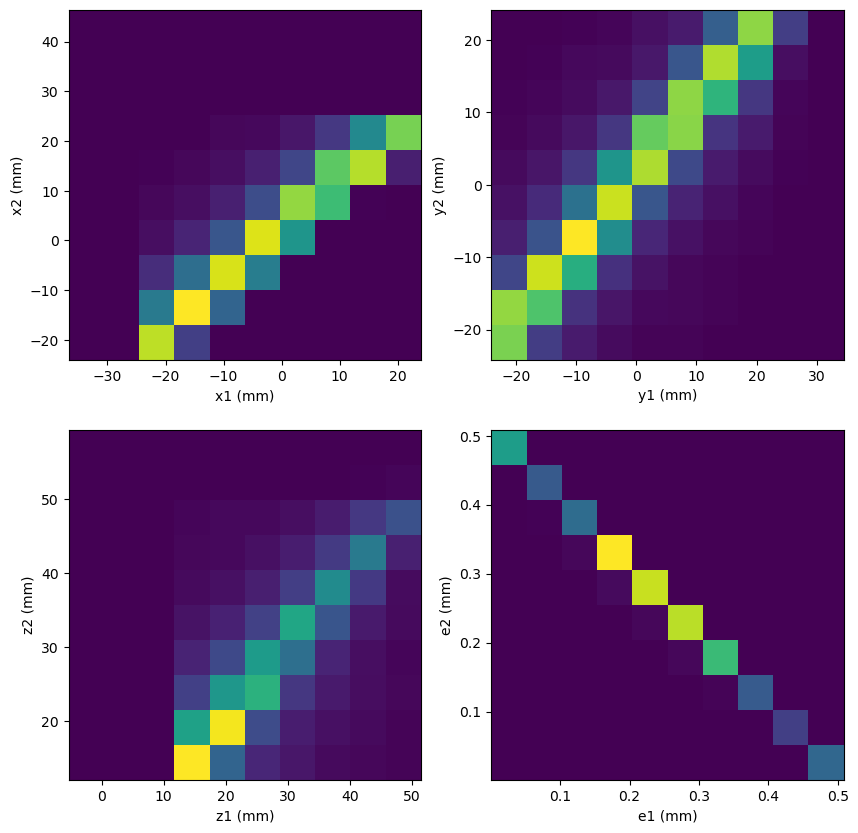

In [78]:
fig, ax = plt.subplots(2, 2, figsize=(10,10))

hxy =ax[0,0].hist2d(gdy2ca.x1, gdy2ca.x2, cmap="viridis",bins=10)
#ax[0].set_aspect('equal')
ax[0,0].set_xlabel('x1 (mm)')
ax[0,0].set_ylabel('x2 (mm)')

hxz =ax[0,1].hist2d(gdy2ca.y1, gdy2ca.y2, cmap="viridis",bins=10)
#ax[1].set_aspect('equal')
ax[0,1].set_xlabel('y1 (mm)')
ax[0,1].set_ylabel('y2 (mm)')

hxz =ax[1,0].hist2d(gdy2ca.z1, gdy2ca.z2, cmap="viridis",bins=10)
#ax[1].set_aspect('equal')
ax[1,0].set_xlabel('z1 (mm)')
ax[1,0].set_ylabel('z2 (mm)')

hxz =ax[1,1].hist2d(gdy2ca.e1, gdy2ca.e2, cmap="viridis",bins=10)
#ax[1].set_aspect('equal')
ax[1,1].set_xlabel('e1 (mm)')
ax[1,1].set_ylabel('e2 (mm)')